In [1]:
# Script to have different ways to train the tactile image
import glob
import h5py
import hydra
import mmap
import numpy as np
import os
import pickle
import torch 
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.utils.data as data 

from omegaconf import DictConfig, OmegaConf
from collections import OrderedDict
from tqdm import tqdm 
from torch.nn.parallel import DistributedDataParallel as DDP
from holobot.robot.allegro.allegro_kdl import AllegroKDL

from tactile_learning.utils.constants import *
from tactile_learning.models.custom import *
from tactile_learning.datasets.tactile_vision import *
from tactile_learning.deployment.load_models import * 
from tactile_learning.deployment.nn_buffer import NearestNeighborBuffer
from tactile_learning.models.knn import KNearestNeighbors, ScaledKNearestNeighbors
from tactile_learning.utils.visualization import *
from tactile_learning.utils.tactile_image import *
from tactile_learning.utils.data import load_data


# Linear Layer to each Tactile Sensor
Here the approach will be as follows: 
1. Turn each small tactile sensor to an image
2. In BYOL after applying the augmentations (which only could be) the encoder will flatten the data
3. And then we'll just have multiple linear layers on top

## Load the data 
Load the data from the play dataset

In [2]:
PLAY_DATA_DIR = '/home/irmak/Workspace/Holo-Bot/extracted_data/tactile_play_data'
PLAY_ROOTS = glob.glob(f'{PLAY_DATA_DIR}/demonstration_*')
play_data = load_data(PLAY_ROOTS)


In [3]:
tactile_value = play_data['tactile']['values']

In [4]:
DEMO_ID = 11
TACTILE_ID = 2000
tactile_values = play_data['tactile']['values'][DEMO_ID][TACTILE_ID]

## Utils methods

In [5]:
from tactile_learning.utils.visualization import plot_tactile_sensor
def plot_tactile_image(ax, tactile_image, tactile_min, tactile_max): # Tactile image should be tensor
    # Map it to 0 and 1 - not super certain this is correct
    # min, max = tactile_image.min(), tactile_image.max()
    img_range = tactile_max - tactile_min
    img = (tactile_image - tactile_min) / img_range
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

In [6]:
def get_small_tactile_image(tactile_value): # tactile_value.shape: (16,3)
    tactile_image = torch.FloatTensor(tactile_value)
    tactile_image = tactile_image.view(4,4,3)
    return torch.permute(tactile_image, (2,0,1))

In [7]:
ex_tact_value = tactile_values[7,:]
ex_tact_img = get_small_tactile_image(ex_tact_value)

## Find the whole mean and std of this images

In [8]:
# Find the whole mean and stds of this data

def get_tactile_image_stats(tactile_values): # tactile_values: data['tactile']['values']
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    min_tactile = 128753929
    max_tactile = -12987349

    pbar = tqdm(total=len(tactile_values.keys()))
    # loop through the images
    total_num_imgs = 0
    for demo_id in tactile_values.keys(): 
        for tactile_id in range(len(tactile_values[demo_id])):
            curr_tactile_values = tactile_values[demo_id][tactile_id]
            for sensor_id in range(curr_tactile_values.shape[0]): # 15
                tactile_img = get_small_tactile_image(curr_tactile_values[sensor_id]).unsqueeze(0) # Act as if this is a batch
                curr_min = tactile_img.min()
                curr_max = tactile_img.max() 
                if curr_min < min_tactile:
                    min_tactile = curr_min 
                if curr_min > max_tactile: 
                    max_tactile = curr_max
                psum += tactile_img.sum(axis = [0,2,3])
                psum_sq += (tactile_img ** 2).sum(axis = [0, 2, 3])
                total_num_imgs += 1
        pbar.update(1)
        pbar.set_description(f'Demo: {demo_id}')

    pbar.close()

    # pixel count
    count = total_num_imgs * 4 * 4

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    # print('mean: '  + str(total_mean))
    # print('std:  '  + str(total_std))

    return total_mean, total_std, min_tactile, max_tactile

In [9]:
TACTILE_MEAN, TACTILE_STD, TACTILE_MIN, TACTILE_MAX = get_tactile_image_stats(play_data['tactile']['values'])

Demo: 12: 100%|██████████| 13/13 [00:38<00:00,  2.93s/it]


In [10]:
print('mean: {}, std: {}, min: {}, max: {}'.format(TACTILE_MEAN, TACTILE_STD, TACTILE_MIN, TACTILE_MAX))

mean: tensor([-6.9900,  3.7022, 10.7355]), std: tensor([189.6929, 156.1941, 132.6691]), min: -18004.39453125, max: 5.199999809265137


In [11]:
def get_augmentations(img_means, img_stds):
    tactile_aug = T.Compose([
        T.RandomApply(
            nn.ModuleList([T.RandomResizedCrop((4,4), scale=(.75, 1))]),
            p = 0.5
        ), 
        T.RandomApply(
            nn.ModuleList([T.GaussianBlur((3, 3), (1.0, 2.0))]), 
            p = 0.5
        ),
        T.Normalize(
            mean = img_means, # NOTE: Wasn't this wrong?
            std = img_stds
        )
    ])
    return tactile_aug

tensor(-0.3736) tensor(0.2577)


Text(0.5, 1.0, 'Augmented Image')

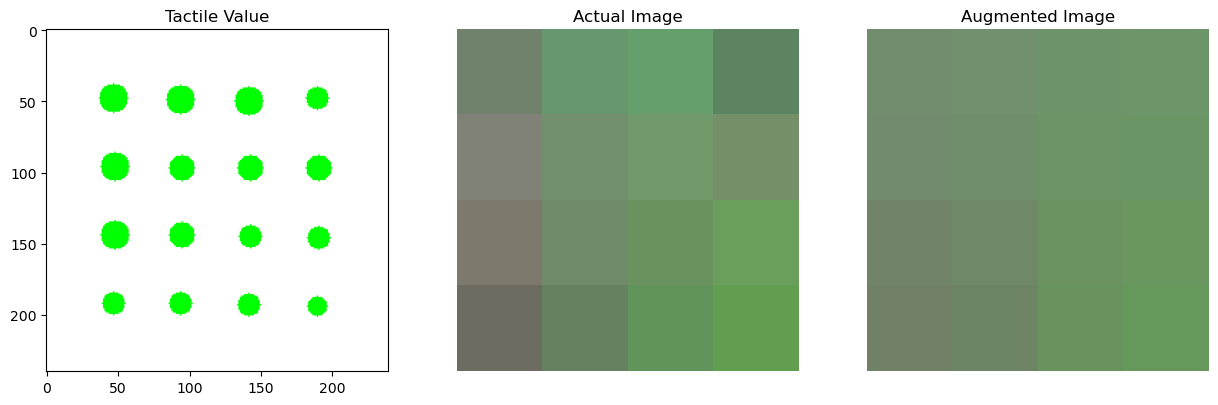

In [12]:
DEMO_ID = 11
TACTILE_ID = 2000
SENSOR_ID = 7
TACTILE_MEAN = torch.FloatTensor([-6.9900,  3.7022, 10.7355])
TACTILE_STD = torch.FloatTensor([189.6929, 156.1941, 132.6691])
tactile_values = play_data['tactile']['values'][DEMO_ID][TACTILE_ID]

ex_tact_value = tactile_values[SENSOR_ID,:]
ex_tact_img = get_small_tactile_image(ex_tact_value)
tactile_aug = get_augmentations(TACTILE_MEAN, TACTILE_STD)
ex_tact_aug_img = tactile_aug(ex_tact_img)
norm_transform = T.Normalize(
    mean = TACTILE_MEAN, std = TACTILE_STD
)
ex_tact_norm_img = norm_transform(ex_tact_img)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_tactile_sensor(axs[0], ex_tact_value)
axs[0].set_title('Tactile Value')
print(ex_tact_norm_img.min(), ex_tact_norm_img.max())
plot_tactile_image(axs[1], ex_tact_norm_img, -1, 1)
axs[1].set_title('Actual Image')
plot_tactile_image(axs[2], ex_tact_aug_img, -1, 1)
axs[2].set_title('Augmented Image')

## Different Encoder Types
1. After normalizing just flatten it
2. Have a separate CNN for each tactile sensor
3. 16x3 channeled CNN

### Implement the only sensor tactile dataset
This dataset should give only sensor tactile images

In [13]:

def get_single_tactile_image(tactile_value):
    tactile_image = torch.FloatTensor(tactile_value)
    tactile_image = tactile_image.view(4,4,3)
    return torch.permute(tactile_image, (2,0,1))

class TactileSensorDataset(data.Dataset):
    def __init__(
        self,
        data_path,
        normalize=False,
        stats=[TACTILE_MEAN, TACTILE_STD], # Will have image means and stds
    ):
        super().__init__()
        self.roots = glob.glob(f'{data_path}/demonstration_*')
        self.roots = sorted(self.roots)
        self.data = load_data(self.roots, demos_to_use=[])
        self.normalize = normalize
        self.normalization_transform = T.Normalize(stats[0], stats[1])
        self._preprocess_tactile_indices()

    def _preprocess_tactile_indices(self):
        self.tactile_mapper = np.zeros(len(self.data['tactile']['indices'])*15).astype(int)
        for data_id in range(len(self.data['tactile']['indices'])):
            for sensor_id in range(15):
                self.tactile_mapper[data_id*15+sensor_id] = data_id # Assign each finger to an index basically

    def _get_sensor_id(self, index):
        return index % 15

    def __len__(self):
        return len(self.tactile_mapper)

    def __getitem__(self, index):
        data_id = self.tactile_mapper[index]
        demo_id, tactile_id = self.data['tactile']['indices'][data_id]
        sensor_id = self._get_sensor_id(index)

        # Get the tactile image
        tactile_value = self.data['tactile']['values'][demo_id][tactile_id][sensor_id]
        tactile_image = get_single_tactile_image(tactile_value)

        if self.normalize:
            return self.normalization_transform(tactile_image)
        else:
            return tactile_image

    def getitem(self, index):
        return self.__getitem__(index) # NOTE: for debugging purposes

In [14]:
dset = TactileSensorDataset(data_path = PLAY_DATA_DIR, normalize=True, stats = [TACTILE_MEAN, TACTILE_STD])
tactile_loader = data.DataLoader(dset, 
                                batch_size  = 32, 
                                shuffle     = False, 
                                num_workers = 4,
                                pin_memory  = True)

min_tactile = 13534
max_tactile = -13834
for batch in tactile_loader:
    curr_min = batch.min() 
    curr_max = batch.max()
    if curr_min < min_tactile:
        min_tactile = curr_min 
    if curr_max > max_tactile: 
        max_tactile = curr_max

print(min_tactile, max_tactile)

TACTILE_MIN = min_tactile 
TACTILE_MAX = max_tactile



tensor(-108.8738) tensor(103.4375)


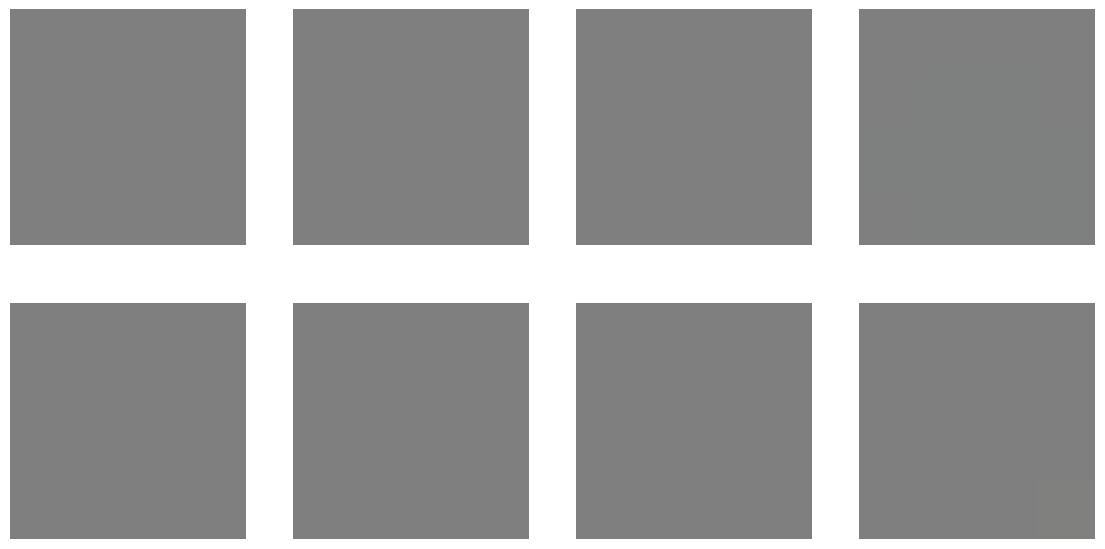

In [15]:
tactile_loader = data.DataLoader(dset, 
                                batch_size  = 32, 
                                shuffle     = True, 
                                num_workers = 4,
                                pin_memory  = True)
# display images
for batch_idx, inputs in enumerate(tactile_loader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plot_tactile_image(ax, inputs[i], -100, 100)
        # plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    break

## Train these encoders with BYOL

### LinearEncoder and Single Sensor CNN
*Encoder* that just flattens the data - after defining the optimizer and adataloaders and stuff we'll use this

In [16]:
class PrintSize(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x.shape)
        return x

class TactileLinearEncoder(nn.Module):
    def __init__(
        self,
        input_dim = 48,
        hidden_dim = 128,
        output_dim = 64
    ):
        super().__init__() 
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        # Flatten the image
        x = torch.flatten(x,1)
        x = self.model(x)
        return x

class TactileSmallEncoder(nn.Module):
    def __init__(
        self,
        in_channels,
        out_dim # Final dimension of the representation
    ):
        super().__init__()
        self.out_dim = out_dim
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=2),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2),
            nn.ReLU(),
            # PrintSize()
        )
        self.linear = nn.Linear(in_features=128, out_features=out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.linear(x)
        return self.relu(x)



In [17]:

from tactile_learning.models.ssl_wrappers.byol import BYOL
from torch.optim import Adam
from torch.utils.data import DataLoader

augment_fn = get_augmentations(TACTILE_IMAGE_MEANS, TACTILE_IMAGE_STDS) # One augment_fn is enough (since it will be the same as augment2)
image_size = 4
learner = BYOL(
    # net = TactileLinearEncoder(
    #     input_dim = 48, # 16 * 3
    #     hidden_dim = 128, 
    #     output_dim = 64
    # ), 
    net = TactileSmallEncoder(
        in_channels=3,
        out_dim=64
    ),
    image_size = image_size,
    augment_fn = augment_fn,
    hidden_layer=-1
)
optimizer = Adam(
    learner.parameters(),
    lr = 1e-2,
    weight_decay = 1e-5
)

dataset = TactileSensorDataset(data_path = PLAY_DATA_DIR, normalize = True)
dataloader = DataLoader(
    dataset, 
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
    pin_memory = True,
)

In [18]:
def train_one_epoch(learner, dataloader, optimizer):
    learner.train()
    total_train_loss = 0

    pbar = tqdm(total=len(dataloader))
    timestep = 0
    for batch in tqdm(dataloader):
        tactile_image = batch
        optimizer.zero_grad()
        loss = learner(tactile_image) 

        loss.backward()
        optimizer.step()
        learner.update_moving_average()

        total_train_loss += loss.item()
        pbar.set_description(f'Train Loss: {loss.item()}')
        pbar.update(1)

        timestep += 1
        if timestep % 100:
            torch.save(learner.state_dict(),
                       'linear_encoder.pt',
                        _use_new_zipfile_serialization=False)

    average_train_loss = total_train_loss / len(dataloader)
    return average_train_loss 

In [19]:
# average_loss = train_one_epoch(learner, dataloader, optimizer)

### 16x3 Stacked Encoder + Dataset
In order to be able to use this setting the dataset for stacked image should also be separate

In [20]:
DEMO_ID = 11
TACTILE_ID = 2000
SENSOR_ID = 7
TACTILE_MEAN = torch.FloatTensor([-6.9900,  3.7022, 10.7355])
TACTILE_STD = torch.FloatTensor([189.6929, 156.1941, 132.6691])
tactile_values = play_data['tactile']['values'][DEMO_ID][TACTILE_ID]
normalization_transform = T.Normalize(TACTILE_MEAN, TACTILE_STD)



tactile_image.shape: torch.Size([45, 4, 4])


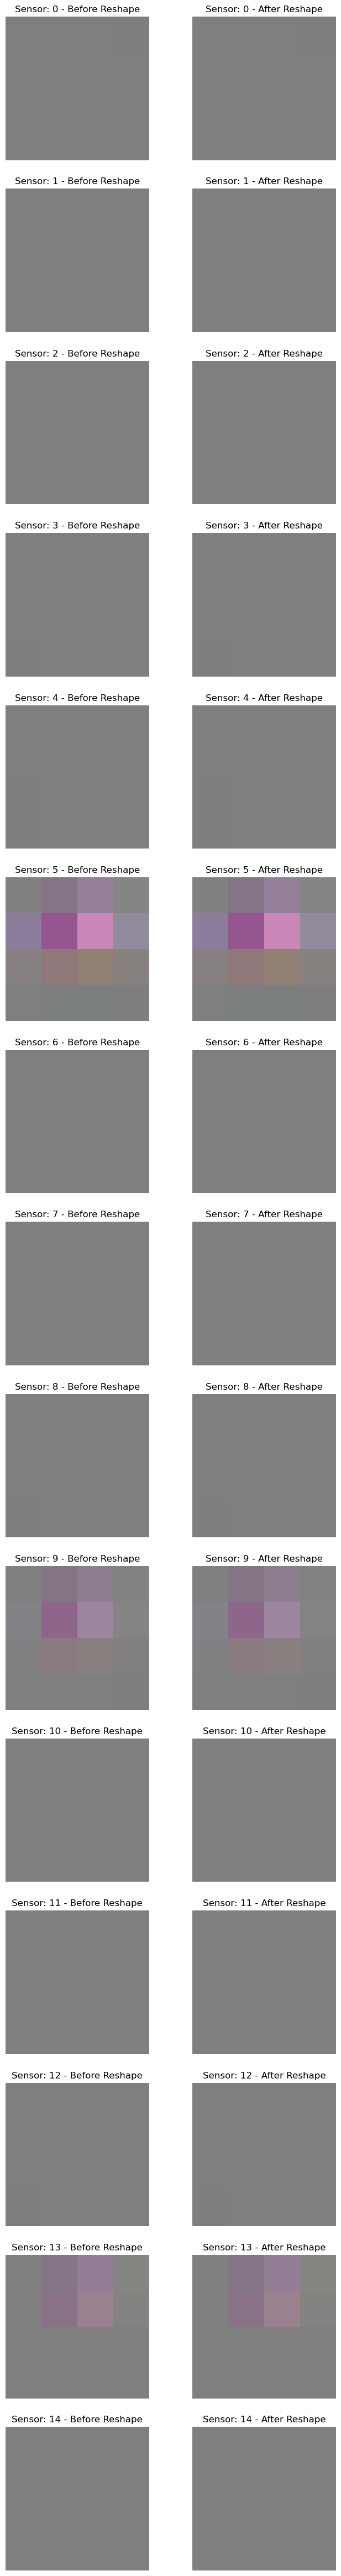

In [21]:
tactile_image = torch.FloatTensor(tactile_values)
tactile_image_pre_reshape = tactile_image.view(15,4,4,3) # Just making sure that everything stays the same
tactile_image_after_reshape = torch.permute(tactile_image_pre_reshape, (0,3,1,2))
tactile_image_after_reshape = tactile_image_after_reshape.reshape(-1,4,4)
# return torch.permute(tactile_image, (2,0,1))
print(f'tactile_image.shape: {tactile_image_after_reshape.shape}')

fig, axs = plt.subplots(nrows=15, ncols=2, figsize=(2*4,15*4))
for sensor_id in range(15):
    # print()
    curr_tactile_image_pre = torch.permute(tactile_image_pre_reshape[sensor_id,:], (2,0,1))
    # print('curr_tactile_image_pre.shape: {}'.format(curr_tactile_image_pre.shape))
    curr_tactile_image_after = tactile_image_after_reshape[sensor_id*3:(sensor_id+1)*3,:]
    # print('curr_tactile_image_after.shape: {}'.format(curr_tactile_image_after.shape))
    plot_tactile_image(
        axs[sensor_id][0],
        normalization_transform(curr_tactile_image_pre), -100, 100)
    axs[sensor_id][0].set_title(f'Sensor: {sensor_id} - Before Reshape')
    plot_tactile_image(axs[sensor_id][1], normalization_transform(curr_tactile_image_after), -100, 100)
    axs[sensor_id][1].set_title(f'Sensor: {sensor_id} - After Reshape')


In [22]:
class TactileStackedEncoder(nn.Module): # Model for 16x3 RGB channelled images
    def __init__(
        self,
        in_channels,
        out_dim # Final dimension of the representation
    ):
        super().__init__()
        self.out_dim = out_dim
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=2),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2),
            nn.ReLU(),
            # PrintSize()
        )
        self.linear = nn.Linear(in_features=128, out_features=out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.linear(x)
        return self.relu(x)

In [23]:
x = [1,2,3]
print(x*3)

[1, 2, 3, 1, 2, 3, 1, 2, 3]


In [24]:
class TactileStackedDataset(data.Dataset): # Dataset that will return 16x3,4,4 images - stacked cnn
    def __init__(
        self,
        data_path,
        normalize=False,
        stats=[TACTILE_IMAGE_MEANS, TACTILE_IMAGE_STDS], # Will have image means and stds
    ):
        super().__init__()
        self.roots = glob.glob(f'{data_path}/demonstration_*')
        self.roots = sorted(self.roots)
        self.data = load_data(self.roots, demos_to_use=[])
        self.normalize = normalize
        self.normalization_transform = T.Normalize(stats[0]*15, stats[1]*15)

    def __len__(self):
        return len(self.data['tactile']['indices'])

    def _get_stacked_tactile_image(self, tactile_values):
        tactile_image = torch.FloatTensor(tactile_values)
        tactile_image = tactile_image.view(15,4,4,3) # Just making sure that everything stays the same
        tactile_image = torch.permute(tactile_image, (0,3,1,2))
        tactile_image = tactile_image.reshape(-1,4,4)

        return tactile_image

    def __getitem__(self, index):
        # Get the tactile image
        demo_id, tactile_id = self.data['tactile']['indices'][index]
        tactile_values = self.data['tactile']['values'][demo_id][tactile_id]
        tactile_image = self._get_stacked_tactile_image(tactile_values)

        if self.normalize:
            return self.normalization_transform(tactile_image)
        else:
            return tactile_image

    def getitem(self, index):
        return self.__getitem__(index) # NOTE: for debugging purposes


75786
torch.Size([75600, 45, 4, 4])


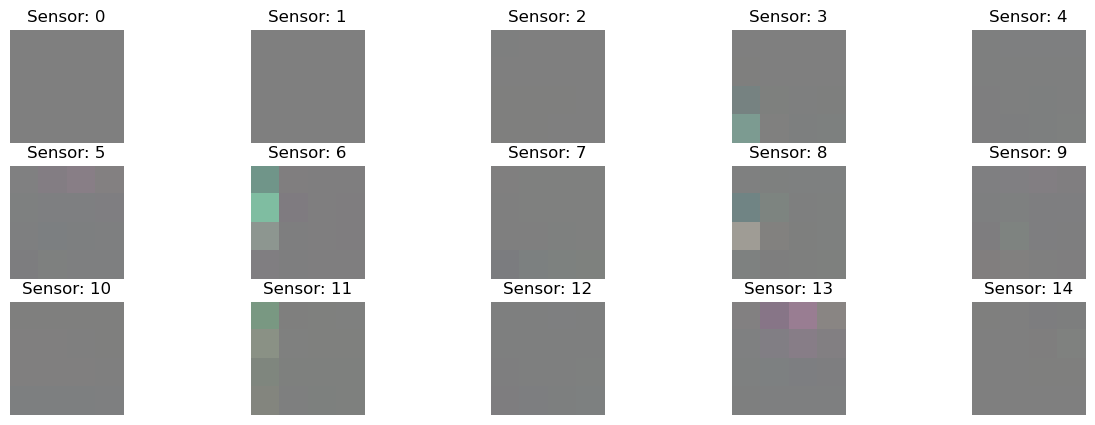

In [25]:
dset = TactileStackedDataset(
    data_path = PLAY_DATA_DIR, 
    normalize = True
)
tactile_loader = data.DataLoader(dset, 
                                batch_size  = 75600, 
                                shuffle     = False, 
                                num_workers = 4,
                                pin_memory  = True)

# display images
print(len(dset))
for batch_idx, inputs in enumerate(tactile_loader):
    print(inputs.shape)
    curr_tactile_value = inputs[30000]
    fig = plt.figure(figsize = (15, 5))
    for sensor_id in range(15):
        ax = fig.add_subplot(3, 5, sensor_id + 1, xticks = [], yticks = [])   
        plot_tactile_image(ax, curr_tactile_value[sensor_id*3:(sensor_id+1)*3], -50, 50)
        ax.set_title(f'Sensor: {sensor_id}')
    break

In [26]:
import copy
import random
from functools import wraps

import torch
from torch import nn
import torch.nn.functional as F

from torchvision import transforms as T

# helper functions

def default(val, def_val):
    return def_val if val is None else val

def flatten(t):
    return t.reshape(t.shape[0], -1)

def singleton(cache_key):
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, **kwargs):
            instance = getattr(self, cache_key)
            if instance is not None:
                return instance

            instance = fn(self, *args, **kwargs)
            setattr(self, cache_key, instance)
            return instance
        return wrapper
    return inner_fn

def get_module_device(module):
    return next(module.parameters()).device

def set_requires_grad(model, val):
    for p in model.parameters():
        p.requires_grad = val

# loss fn

def loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

# augmentation utils

class RandomApply(nn.Module):
    def __init__(self, fn, p):
        super().__init__()
        self.fn = fn
        self.p = p
    def forward(self, x):
        if random.random() > self.p:
            return x
        return self.fn(x)

# exponential moving average

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

# MLP class for projector and predictor

def MLP(dim, projection_size, hidden_size=4096):
    return nn.Sequential(
        nn.Linear(dim, hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, projection_size)
    )

def SimSiamMLP(dim, projection_size, hidden_size=4096):
    return nn.Sequential(
        nn.Linear(dim, hidden_size, bias=False),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, hidden_size, bias=False),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, projection_size, bias=False),
        nn.BatchNorm1d(projection_size, affine=False)
    )

# a wrapper class for the base neural network
# will manage the interception of the hidden layer output
# and pipe it into the projecter and predictor nets

class NetWrapper(nn.Module):
    def __init__(self, net, projection_size, projection_hidden_size, layer = -2, use_simsiam_mlp = False):
        super().__init__()
        self.net = net
        self.layer = layer

        self.projector = None
        self.projection_size = projection_size
        self.projection_hidden_size = projection_hidden_size

        self.use_simsiam_mlp = use_simsiam_mlp

        self.hidden = {}
        self.hook_registered = False

    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None

    def _hook(self, _, input, output):
        device = input[0].device
        self.hidden[device] = flatten(output)

    def _register_hook(self):
        layer = self._find_layer()
        assert layer is not None, f'hidden layer ({self.layer}) not found'
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True

    @singleton('projector')
    def _get_projector(self, hidden):
        _, dim = hidden.shape
        create_mlp_fn = MLP if not self.use_simsiam_mlp else SimSiamMLP
        projector = create_mlp_fn(dim, self.projection_size, self.projection_hidden_size)
        return projector.to(hidden)

    def get_representation(self, x):
        if self.layer == -1:
            return self.net(x)

        if not self.hook_registered:
            self._register_hook()

        self.hidden.clear()
        _ = self.net(x)
        hidden = self.hidden[x.device]
        self.hidden.clear()

        assert hidden is not None, f'hidden layer {self.layer} never emitted an output'
        return hidden

    def forward(self, x, return_projection = True):
        representation = self.get_representation(x)

        if not return_projection:
            return representation

        projector = self._get_projector(representation)
        projection = projector(representation)
        return projection, representation

# main class

class BYOL(nn.Module):
    def __init__(
        self,
        net,
        image_size,
        hidden_layer = -2,
        projection_size = 256,
        projection_hidden_size = 4096,
        augment_fn = None,
        augment_fn2 = None,
        moving_average_decay = 0.99,
        use_momentum = True,
        in_channels = 3 # If the encoder has more than 1 channels
    ):
        super().__init__()
        self.net = net

        # default SimCLR augmentation

        DEFAULT_AUG = torch.nn.Sequential(
            RandomApply(
                T.ColorJitter(0.8, 0.8, 0.8, 0.2),
                p = 0.3
            ),
            T.RandomGrayscale(p=0.2),
            T.RandomHorizontalFlip(),
            RandomApply(
                T.GaussianBlur((3, 3), (1.0, 2.0)),
                p = 0.2
            ),
            T.RandomResizedCrop((image_size, image_size)),
            T.Normalize(
                mean=torch.tensor([0.485, 0.456, 0.406]),
                std=torch.tensor([0.229, 0.224, 0.225])),
        )

        self.augment1 = default(augment_fn, DEFAULT_AUG)
        self.augment2 = default(augment_fn2, self.augment1)

        self.online_encoder = NetWrapper(net, projection_size, projection_hidden_size, layer=hidden_layer, use_simsiam_mlp=not use_momentum)

        self.use_momentum = use_momentum
        self.target_encoder = None
        self.target_ema_updater = EMA(moving_average_decay)

        self.online_predictor = MLP(projection_size, projection_size, projection_hidden_size)

        # get device of network and make wrapper same device
        device = get_module_device(net)
        self.to(device)

        # send a mock image tensor to instantiate singleton parameters
        self.forward(torch.randn(2, in_channels, image_size, image_size, device=device))

    @singleton('target_encoder')
    def _get_target_encoder(self):
        target_encoder = copy.deepcopy(self.online_encoder)
        set_requires_grad(target_encoder, False)
        return target_encoder

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_moving_average(self):
        assert self.use_momentum, 'you do not need to update the moving average, since you have turned off momentum for the target encoder'
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(
        self,
        x,
        return_embedding = False,
        return_projection = True
    ):
        assert not (self.training and x.shape[0] == 1), 'you must have greater than 1 sample when training, due to the batchnorm in the projection layer'

        if return_embedding:
            return self.online_encoder(x, return_projection = return_projection)

        image_one, image_two = self.augment1(x), self.augment2(x)

        online_proj_one, _ = self.online_encoder(image_one)
        online_proj_two, _ = self.online_encoder(image_two)

        online_pred_one = self.online_predictor(online_proj_one)
        online_pred_two = self.online_predictor(online_proj_two)

        with torch.no_grad():
            target_encoder = self._get_target_encoder() if self.use_momentum else self.online_encoder
            target_proj_one, _ = target_encoder(image_one)
            target_proj_two, _ = target_encoder(image_two)
            target_proj_one.detach_()
            target_proj_two.detach_()

        loss_one = loss_fn(online_pred_one, target_proj_two.detach())
        loss_two = loss_fn(online_pred_two, target_proj_one.detach())

        loss = loss_one + loss_two
        return loss.mean()

In [27]:
def get_augmentations(img_means, img_stds):
    tactile_aug = T.Compose([
        T.RandomApply(
            nn.ModuleList([T.RandomResizedCrop((4,4), scale=(.75, 1))]),
            p = 0.5
        ), 
        T.RandomApply(
            nn.ModuleList([T.GaussianBlur((3, 3), (1.0, 2.0))]), 
            p = 0.5
        ),
        T.Normalize(
            mean = img_means, # NOTE: Wasn't this wrong?
            std = img_stds
        )
    ])
    return tactile_aug

In [28]:

from tactile_learning.models.ssl_wrappers.byol import BYOL
from torch.optim import Adam
from torch.utils.data import DataLoader

augment_fn = get_augmentations(TACTILE_IMAGE_MEANS*15, TACTILE_IMAGE_STDS*15) # One augment_fn is enough (since it will be the same as augment2)
image_size = 4
learner = BYOL(
    net = TactileStackedEncoder(
        in_channels=45,
        out_dim=128
    ),
    image_size = image_size,
    augment_fn = augment_fn,
    in_channels=45
)
optimizer = Adam(
    learner.parameters(),
    lr = 1e-2,
    weight_decay = 1e-5
)

dataset = TactileStackedDataset(data_path = PLAY_DATA_DIR, normalize = False)
dataloader = DataLoader(
    dataset, 
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
    pin_memory = True,
)

In [29]:
def train_one_epoch(learner, dataloader, optimizer):
    learner.train()
    total_train_loss = 0

    pbar = tqdm(total=len(dataloader))
    timestep = 0
    for batch in tqdm(dataloader):
        tactile_image = batch
        optimizer.zero_grad()
        loss = learner(tactile_image) 

        loss.backward()
        optimizer.step()
        learner.update_moving_average()

        total_train_loss += loss.item()
        pbar.set_description(f'Train Loss: {loss.item()}')
        pbar.update(1)

        timestep += 1
        if timestep % 100:
            torch.save(learner.state_dict(),
                       'stacked_cnn.pt',
                        _use_new_zipfile_serialization=False)

    average_train_loss = total_train_loss / len(dataloader)
    return average_train_loss 

In [30]:
average_loss = train_one_epoch(learner, dataloader, optimizer)

Train Loss: 0.020671581849455833: 100%|██████████| 2369/2369 [23:05<00:00,  1.71it/s]
